In [1]:
import warnings
warnings.filterwarnings("ignore")

# Data Visualization
import missingno
import seaborn as sns
import matplotlib.pyplot as plt

# Basic - Data Handling
import numpy as np
import pandas as pd

# Data Imputation
from missingpy import MissForest

## Read the Data

In [2]:
X_train = pd.read_csv('datasets/train_x.csv').drop(['ID'], axis=1)
y_train = pd.read_csv('datasets/train_y.csv')["Label"]
X_test = pd.read_csv('datasets/test_x.csv').drop(["ID_Test"], axis=1)

In [3]:
display(X_train.head())
display(X_test.head())

,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1830.943788,14767.28013,B,Y,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291
1,1645.302546,15272.26775,B,Y,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455
2,1555.026392,17482.49734,A,Y,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886
3,NaN,16257.66493,A,Y,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849
4,1777.648916,16316.29914,B,X,1.0,NaN,224.074728,11.218489,605.947340,3438.864083


,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1780.356350,16691.51975,B,X,1,0.348808,226.896383,12.506668,607.396052,3440.172169
1,1939.547945,14782.20015,A,Z,0,0.426270,125.046903,12.976712,599.808710,3517.084962
2,1721.876977,14035.40923,B,Z,0,0.097577,181.636946,5.501962,596.344664,3411.918090
3,1681.268538,15179.79116,A,Z,0,0.295460,151.320572,3.058352,597.761361,3392.298282
4,1654.495928,15187.09603,A,Y,0,0.272479,178.429450,4.571414,600.006307,3379.363201


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Expense          77956 non-null  float64
 1   Income           78045 non-null  float64
 2   Loan type        77989 non-null  object 
 3   Occupation type  78141 non-null  object 
 4   Age              77986 non-null  float64
 5   Score1           78060 non-null  float64
 6   Score2           77964 non-null  float64
 7   Score3           78045 non-null  float64
 8   Score4           78028 non-null  float64
 9   Score5           78002 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.1+ MB


In [5]:
X_train.describe()

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5
count,77956.000000,78045.000000,77986.000000,78060.000000,77964.000000,78045.000000,78028.000000,78002.000000
mean,1733.993769,15641.112448,0.441105,0.187617,192.065584,9.365450,600.397742,3417.740403
std,133.239147,1065.620737,0.496522,0.123509,28.558250,8.760134,3.826112,64.391844
min,1126.809192,11171.703240,0.000000,-0.563328,40.572797,-28.885235,581.806404,3124.413430
25%,1644.263974,14925.658150,0.000000,0.112651,173.415940,3.514901,597.894759,3374.406833
50%,1736.276720,15624.259290,0.000000,0.189877,191.056193,8.883862,600.095436,3418.793524
75%,1824.376793,16346.084990,1.000000,0.265243,209.727593,14.746607,602.597131,3461.384283
max,2309.129903,20728.915330,1.000000,0.705737,338.073551,50.691479,619.623108,3692.731924


## Visualize the missing Data

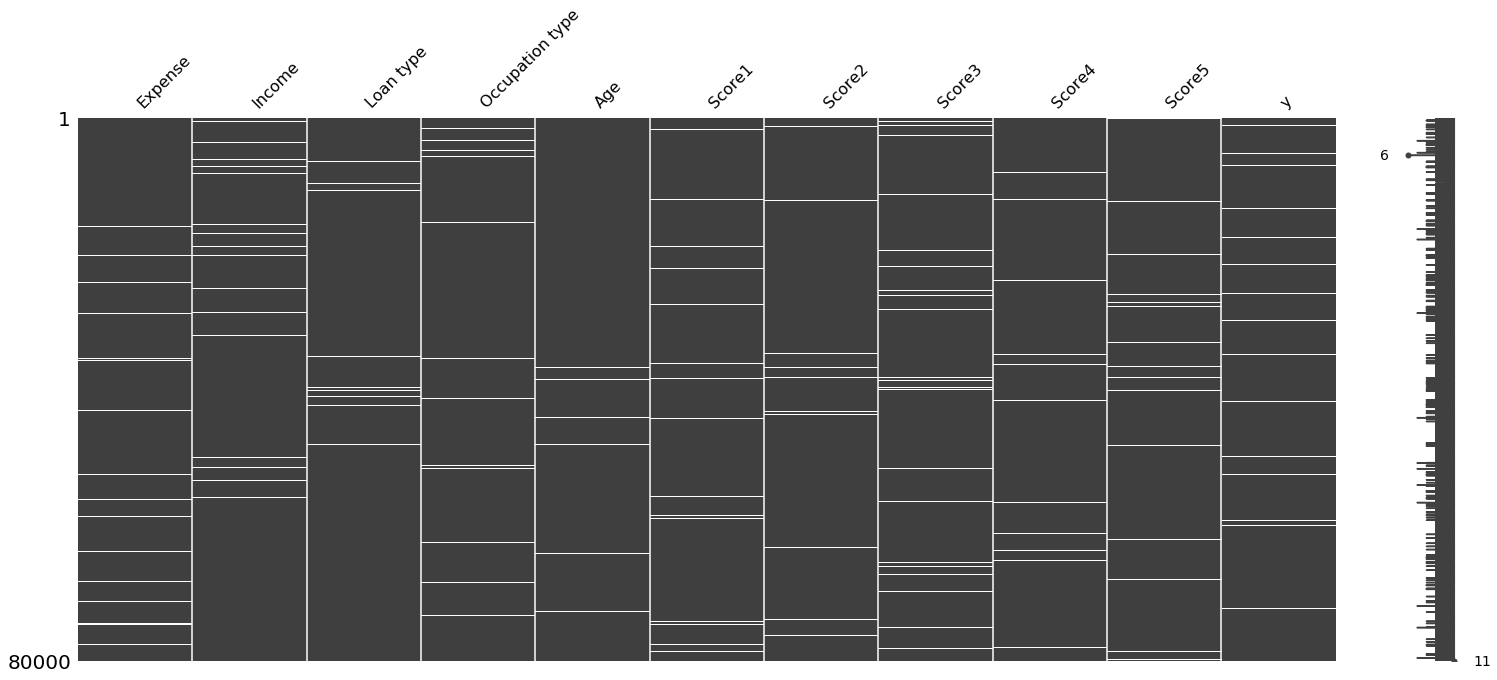

In [6]:
X_appended = X_train.copy()
X_appended["y"] = y_train
missingno.matrix(X_appended)
plt.show()

In [7]:
X_appended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Expense          77956 non-null  float64
 1   Income           78045 non-null  float64
 2   Loan type        77989 non-null  object 
 3   Occupation type  78141 non-null  object 
 4   Age              77986 non-null  float64
 5   Score1           78060 non-null  float64
 6   Score2           77964 non-null  float64
 7   Score3           78045 non-null  float64
 8   Score4           78028 non-null  float64
 9   Score5           78002 non-null  float64
 10  y                76097 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.7+ MB


## Perform Imputation

In [8]:
def imputation_preprocessing(df):
    # Changing to int and then category for imputation
    # https://pbpython.com/pandas_dtypes_cat.html
    X_appended = df.replace(['A', 'B', 'X', 'Y', 'Z'], [0, 1, 0, 1, 2])
    X_appended["Age"] = X_appended["Age"].astype('category')
    X_appended["Occupation type"] = X_appended["Occupation type"].astype('category')
    X_appended["Loan type"] = X_appended["Loan type"].astype('category')
    if 'y' in df.columns:
        X_appended["y"] = X_appended["y"].astype('category')

    cat_vars = list(np.where(X_appended.dtypes=='category')[0])
    print(X_appended.dtypes)
    print("\nCategorical Variables:", cat_vars)
    print("="*50)
    
    return X_appended, cat_vars

In [9]:
# Performing Missing Forest Imputation
X_appended, cat_vars = imputation_preprocessing(X_appended)
X_test_appended, test_cat_vars = imputation_preprocessing(X_test)

imputer = MissForest(random_state=42)
X_imputed = imputer.fit_transform(X_appended, cat_vars=cat_vars)
X_imputed = pd.DataFrame(X_imputed, columns=X_appended.columns)

imputer = MissForest(random_state=42)
X_test_imputed = imputer.fit_transform(X_test_appended, cat_vars=test_cat_vars)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Save the  imputed data as a backup
X_imputed.to_csv("datasets/train_rf_imputed.csv")
X_test_imputed.to_csv("datasets/test_rf_imputed.csv")

# Display the imputed data
display(X_imputed)
display(X_test_imputed)

Expense             float64
Income              float64
Loan type          category
Occupation type    category
Age                category
Score1              float64
Score2              float64
Score3              float64
Score4              float64
Score5              float64
y                  category
dtype: object

Categorical Variables: [2, 3, 4, 10]
Expense             float64
Income              float64
Loan type          category
Occupation type    category
Age                category
Score1              float64
Score2              float64
Score3              float64
Score4              float64
Score5              float64
dtype: object

Categorical Variables: [2, 3, 4]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5,y
0,1830.943788,14767.28013,1.0,1.0,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291,0.0
1,1645.302546,15272.26775,1.0,1.0,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455,0.0
2,1555.026392,17482.49734,0.0,1.0,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886,0.0
3,1681.231935,16257.66493,0.0,1.0,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849,0.0
4,1777.648916,16316.29914,1.0,0.0,1.0,0.301090,224.074728,11.218489,605.947340,3438.864083,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79995,1470.317116,16659.49663,0.0,2.0,0.0,0.208757,172.526308,-5.332184,596.648261,3290.377932,0.0
79996,1923.617480,14910.36890,1.0,1.0,0.0,0.201837,186.252458,15.425841,600.855069,3509.388221,0.0
79997,1711.147154,15962.25945,0.0,1.0,1.0,0.226396,196.098150,8.161353,601.360722,3406.734018,0.0
79998,1673.822523,15525.27413,1.0,2.0,0.0,0.101090,186.390184,3.381393,596.750750,3388.700770,0.0


,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5
0,1780.356350,16691.51975,1.0,0.0,1.0,0.348808,226.896383,12.506668,607.396052,3440.172169
1,1939.547945,14782.20015,0.0,2.0,0.0,0.426270,125.046903,12.976712,599.808710,3517.084962
2,1721.876977,14035.40923,1.0,2.0,0.0,0.097577,181.636946,5.501962,596.344664,3411.918090
3,1681.268538,15179.79116,0.0,2.0,0.0,0.295460,151.320572,3.058352,597.761361,3392.298282
4,1654.495928,15187.09603,0.0,1.0,0.0,0.272479,178.429450,4.571414,600.006307,3379.363201
...,...,...,...,...,...,...,...,...,...,...
19995,1706.038470,15388.07701,1.0,2.0,0.0,0.080845,192.079189,1.100830,595.979156,3404.265778
19996,1712.503287,17979.80449,1.0,0.0,1.0,-0.025641,228.686449,11.394893,600.071790,3407.389229
19997,1873.089949,17804.74995,1.0,1.0,1.0,0.068247,236.021469,4.680945,599.961820,3484.976043
19998,1740.115898,17071.77542,1.0,0.0,1.0,0.032874,231.595185,12.147134,601.404096,3420.730153


Expense            0
Income             0
Loan type          0
Occupation type    0
Age                0
Score1             0
Score2             0
Score3             0
Score4             0
Score5             0
y                  0
dtype: int64

Expense            0
Income             0
Loan type          0
Occupation type    0
Age                0
Score1             0
Score2             0
Score3             0
Score4             0
Score5             0
dtype: int64

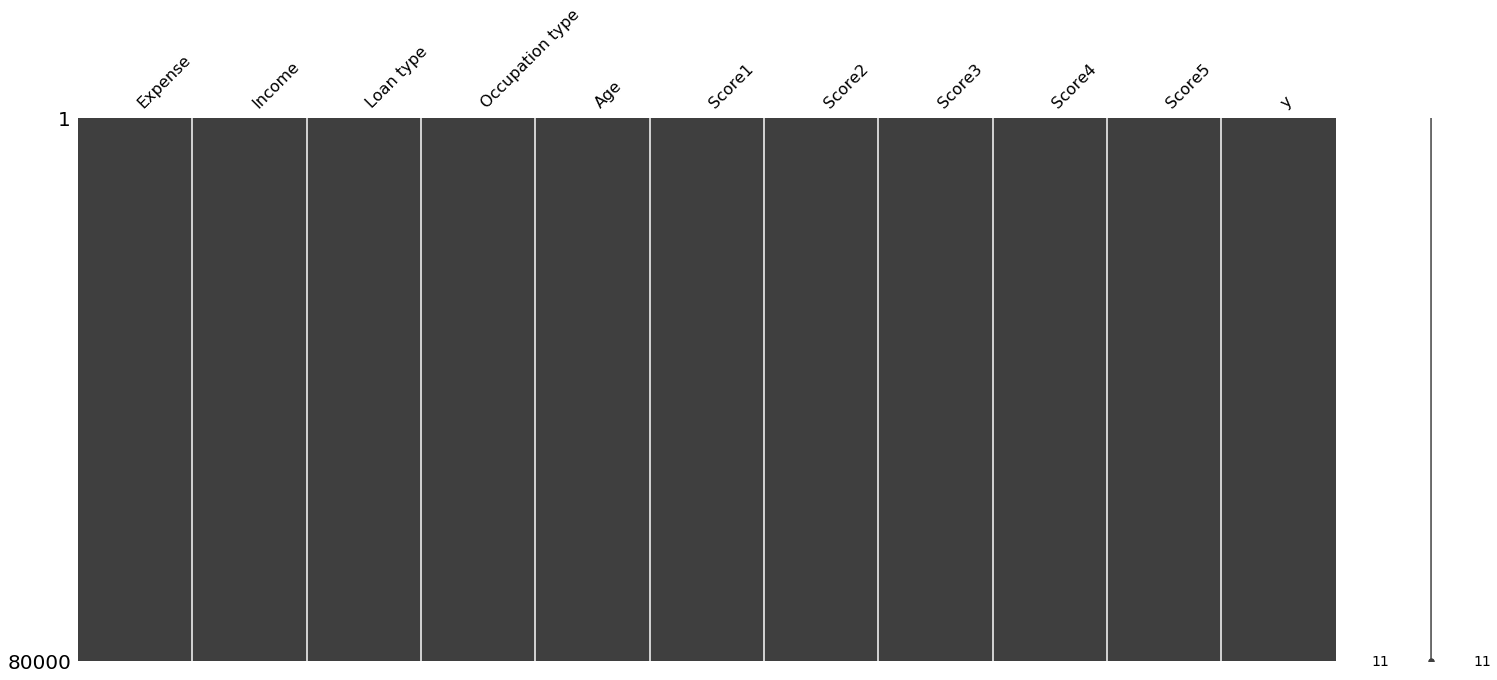

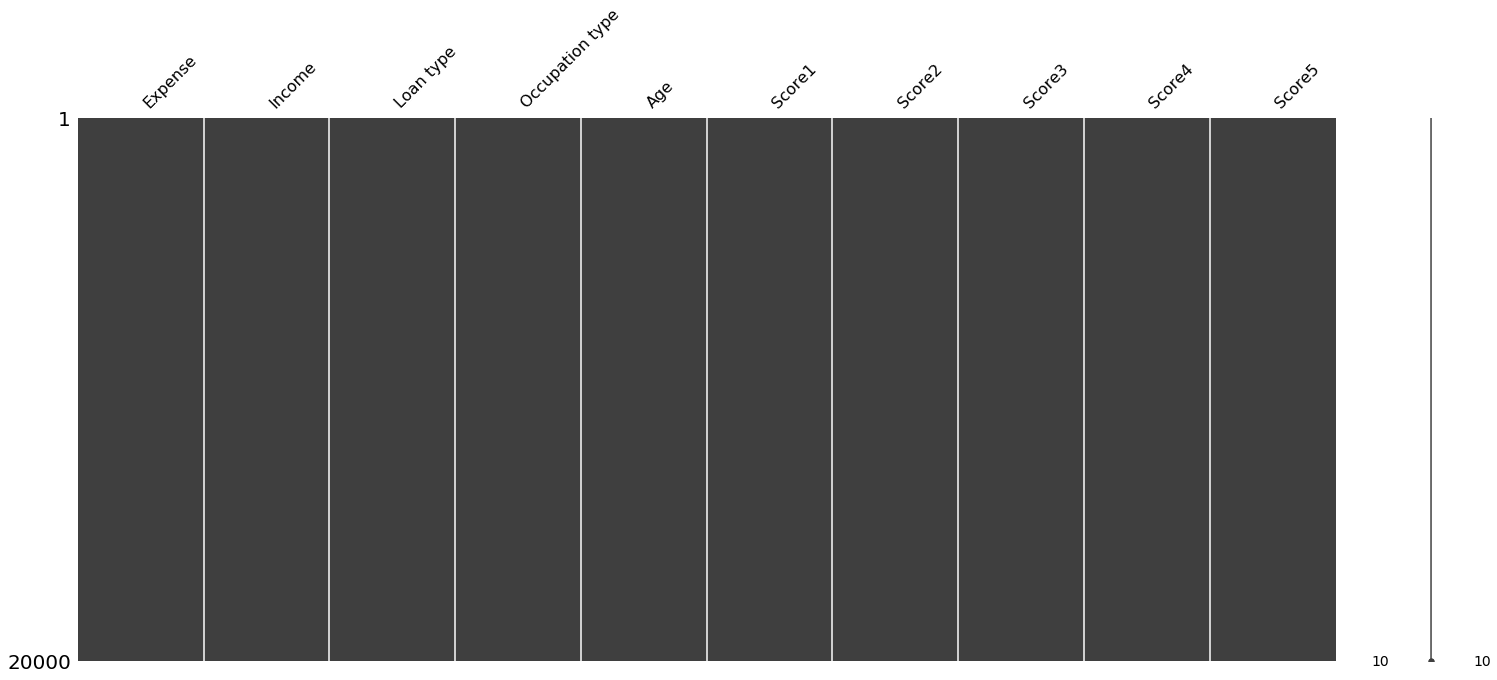

In [10]:
display(X_imputed.isnull().sum())
display(X_test_imputed.isnull().sum())

missingno.matrix(X_imputed)
plt.show()

missingno.matrix(X_test_imputed)
plt.show()

## One-Hot Encoding

In [11]:
# Train - One hot encoding
df = pd.get_dummies(X_imputed, columns=["Loan type", "Occupation type"], drop_first=True)
display(df)

# Test - One hot encoding
df_test = pd.get_dummies(X_test_imputed, columns=["Loan type", "Occupation type"], drop_first=True)
display(df_test)

,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,y,Loan type_1.0,Occupation type_1.0,Occupation type_2.0
0,1830.943788,14767.28013,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291,0.0,1,1,0
1,1645.302546,15272.26775,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455,0.0,1,1,0
2,1555.026392,17482.49734,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886,0.0,0,1,0
3,1681.231935,16257.66493,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849,0.0,0,1,0
4,1777.648916,16316.29914,1.0,0.301090,224.074728,11.218489,605.947340,3438.864083,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1470.317116,16659.49663,0.0,0.208757,172.526308,-5.332184,596.648261,3290.377932,0.0,0,0,1
79996,1923.617480,14910.36890,0.0,0.201837,186.252458,15.425841,600.855069,3509.388221,0.0,1,1,0
79997,1711.147154,15962.25945,1.0,0.226396,196.098150,8.161353,601.360722,3406.734018,0.0,0,1,0
79998,1673.822523,15525.27413,0.0,0.101090,186.390184,3.381393,596.750750,3388.700770,0.0,1,0,1


,Expense,Income,Age,Score1,Score2,Score3,Score4,Score5,Loan type_1.0,Occupation type_1.0,Occupation type_2.0
0,1780.356350,16691.51975,1.0,0.348808,226.896383,12.506668,607.396052,3440.172169,1,0,0
1,1939.547945,14782.20015,0.0,0.426270,125.046903,12.976712,599.808710,3517.084962,0,0,1
2,1721.876977,14035.40923,0.0,0.097577,181.636946,5.501962,596.344664,3411.918090,1,0,1
3,1681.268538,15179.79116,0.0,0.295460,151.320572,3.058352,597.761361,3392.298282,0,0,1
4,1654.495928,15187.09603,0.0,0.272479,178.429450,4.571414,600.006307,3379.363201,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,1706.038470,15388.07701,0.0,0.080845,192.079189,1.100830,595.979156,3404.265778,1,0,1
19996,1712.503287,17979.80449,1.0,-0.025641,228.686449,11.394893,600.071790,3407.389229,1,0,0
19997,1873.089949,17804.74995,1.0,0.068247,236.021469,4.680945,599.961820,3484.976043,1,1,0
19998,1740.115898,17071.77542,1.0,0.032874,231.595185,12.147134,601.404096,3420.730153,1,0,0


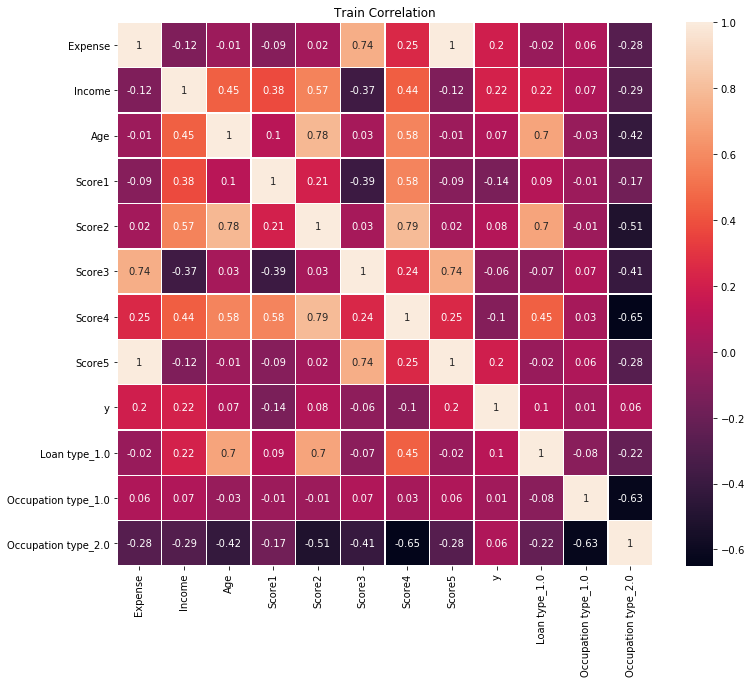

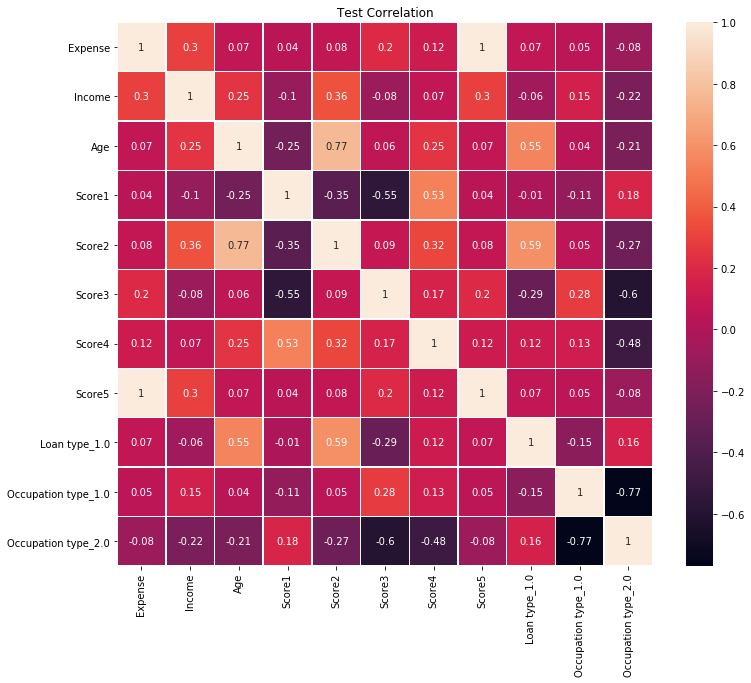

In [12]:
plt.figure(figsize=[12,10])
plt.title("Train Correlation")
sns.heatmap(df.corr().round(2), linewidths=.5, annot=True)
plt.show()

plt.figure(figsize=[12,10])
plt.title("Test Correlation")
sns.heatmap(df_test.corr().round(2), linewidths=.5, annot=True)
plt.show()

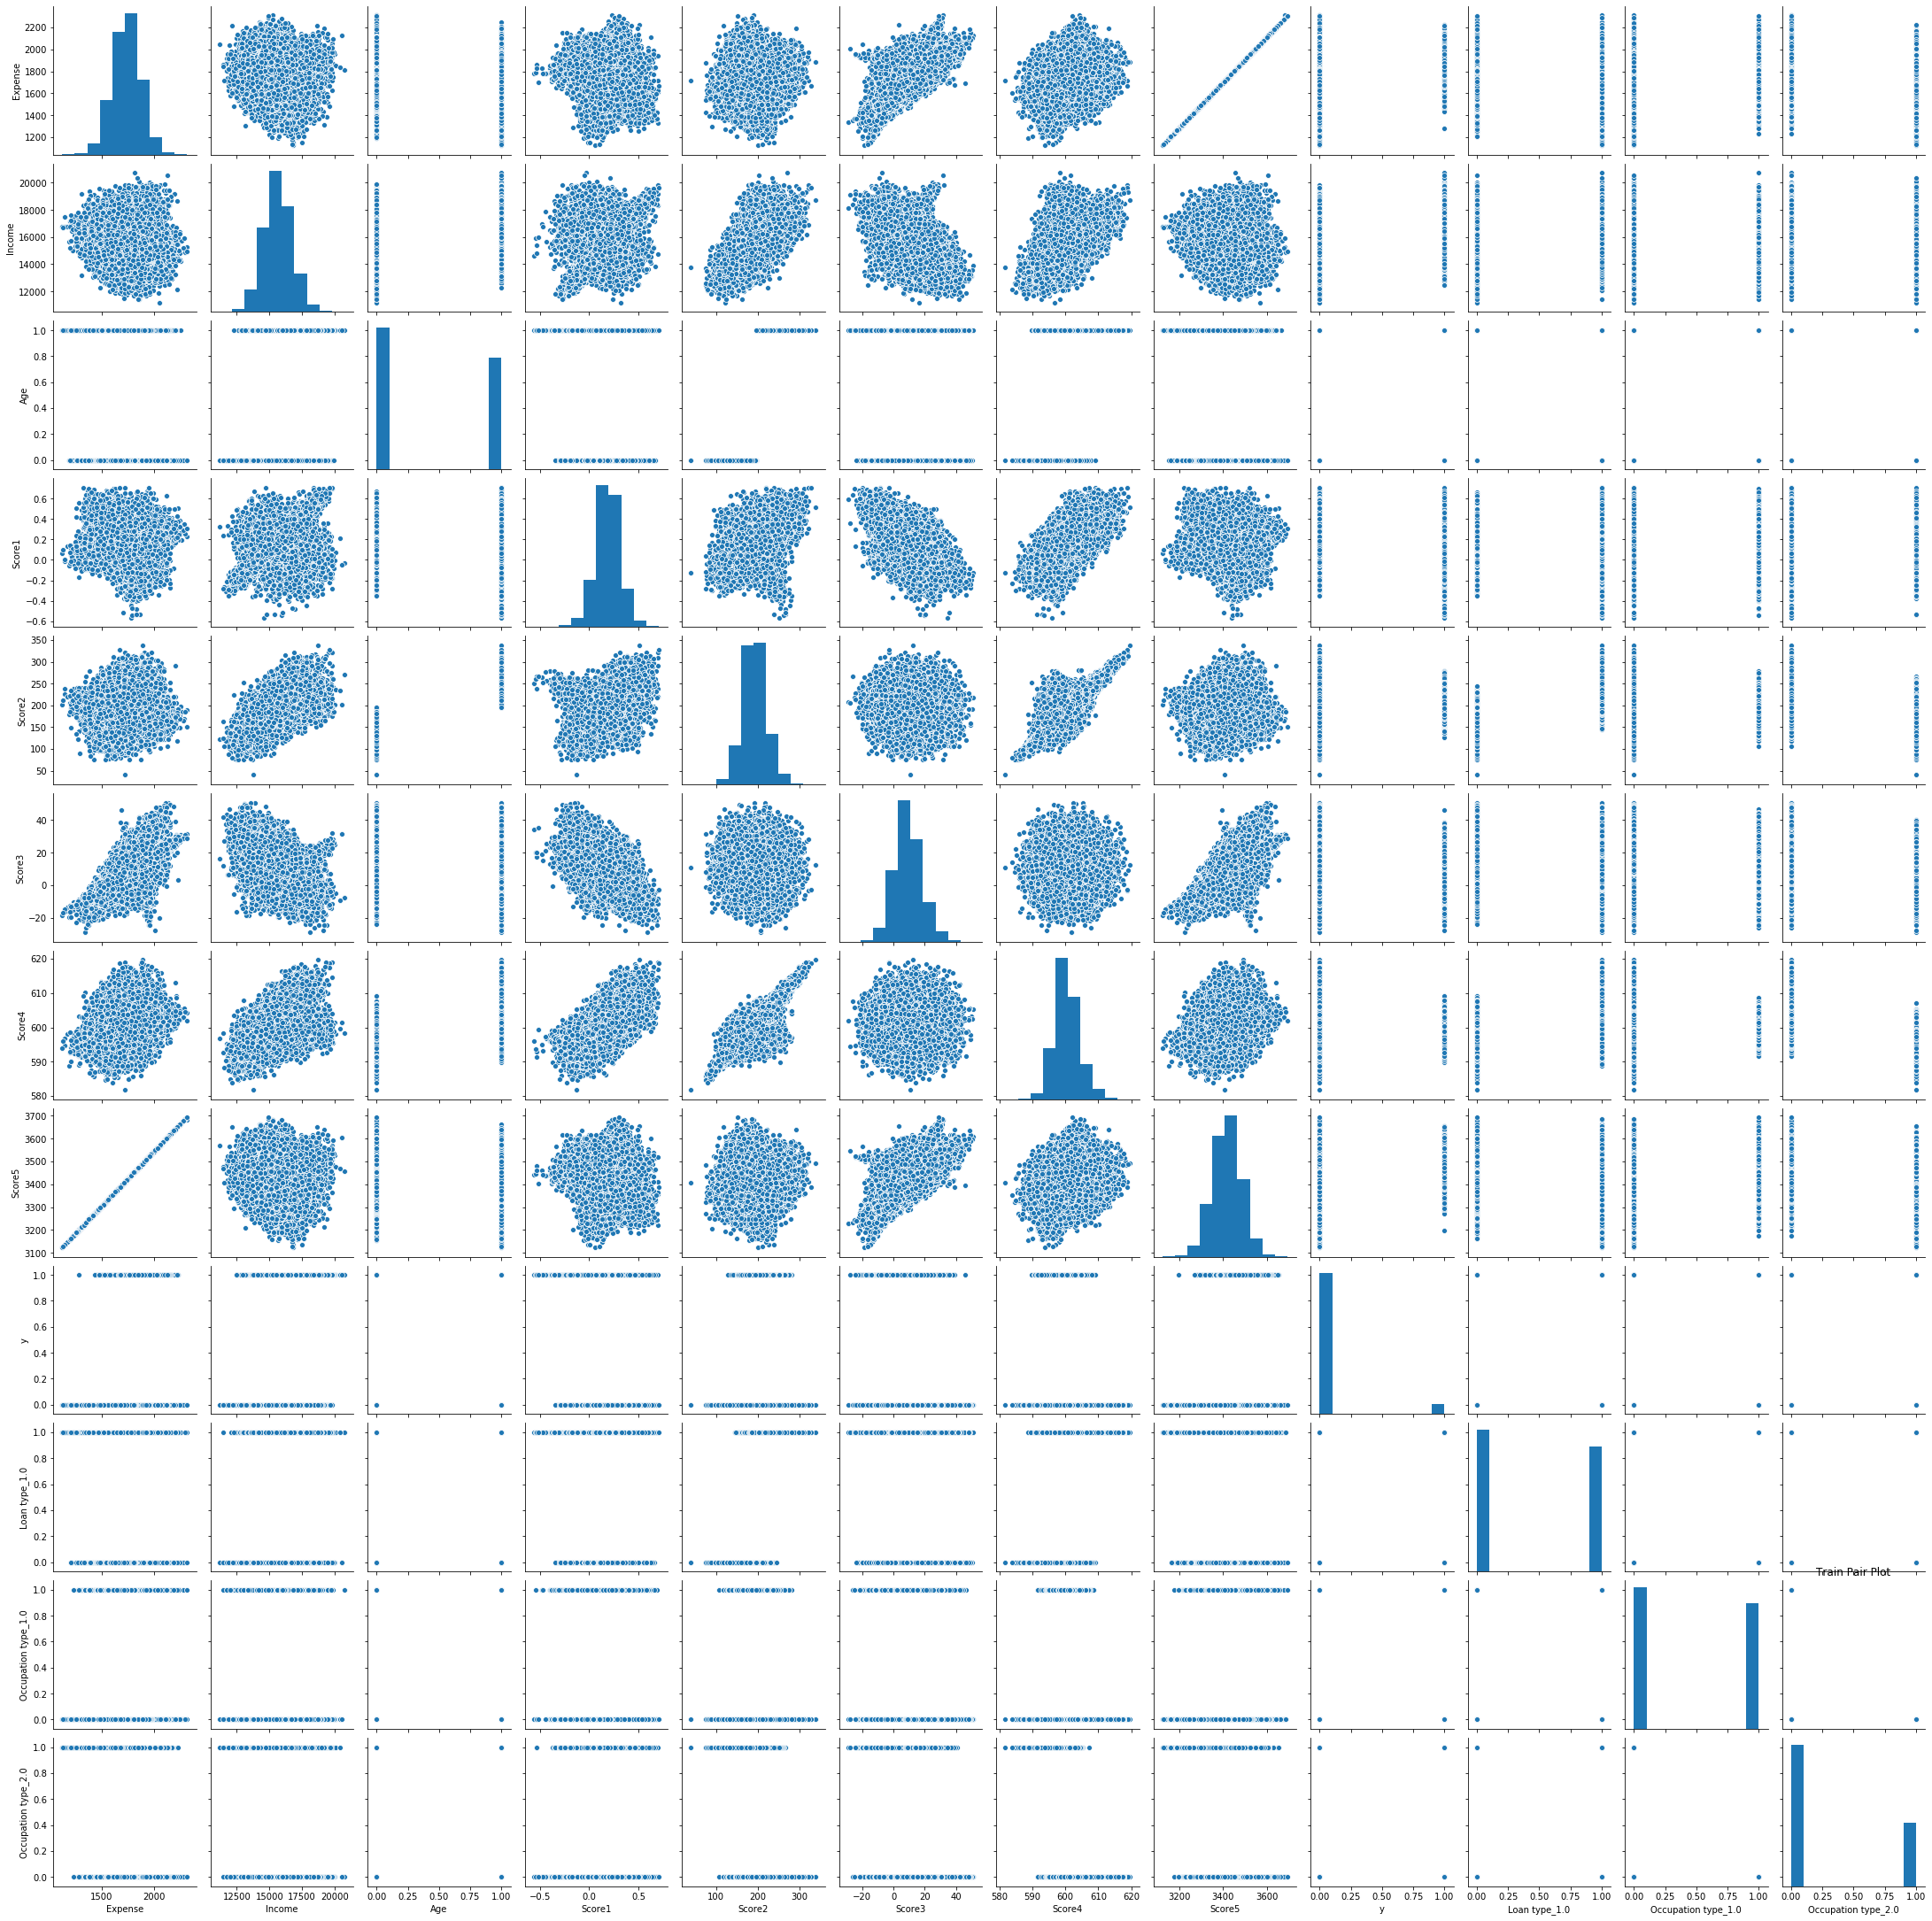

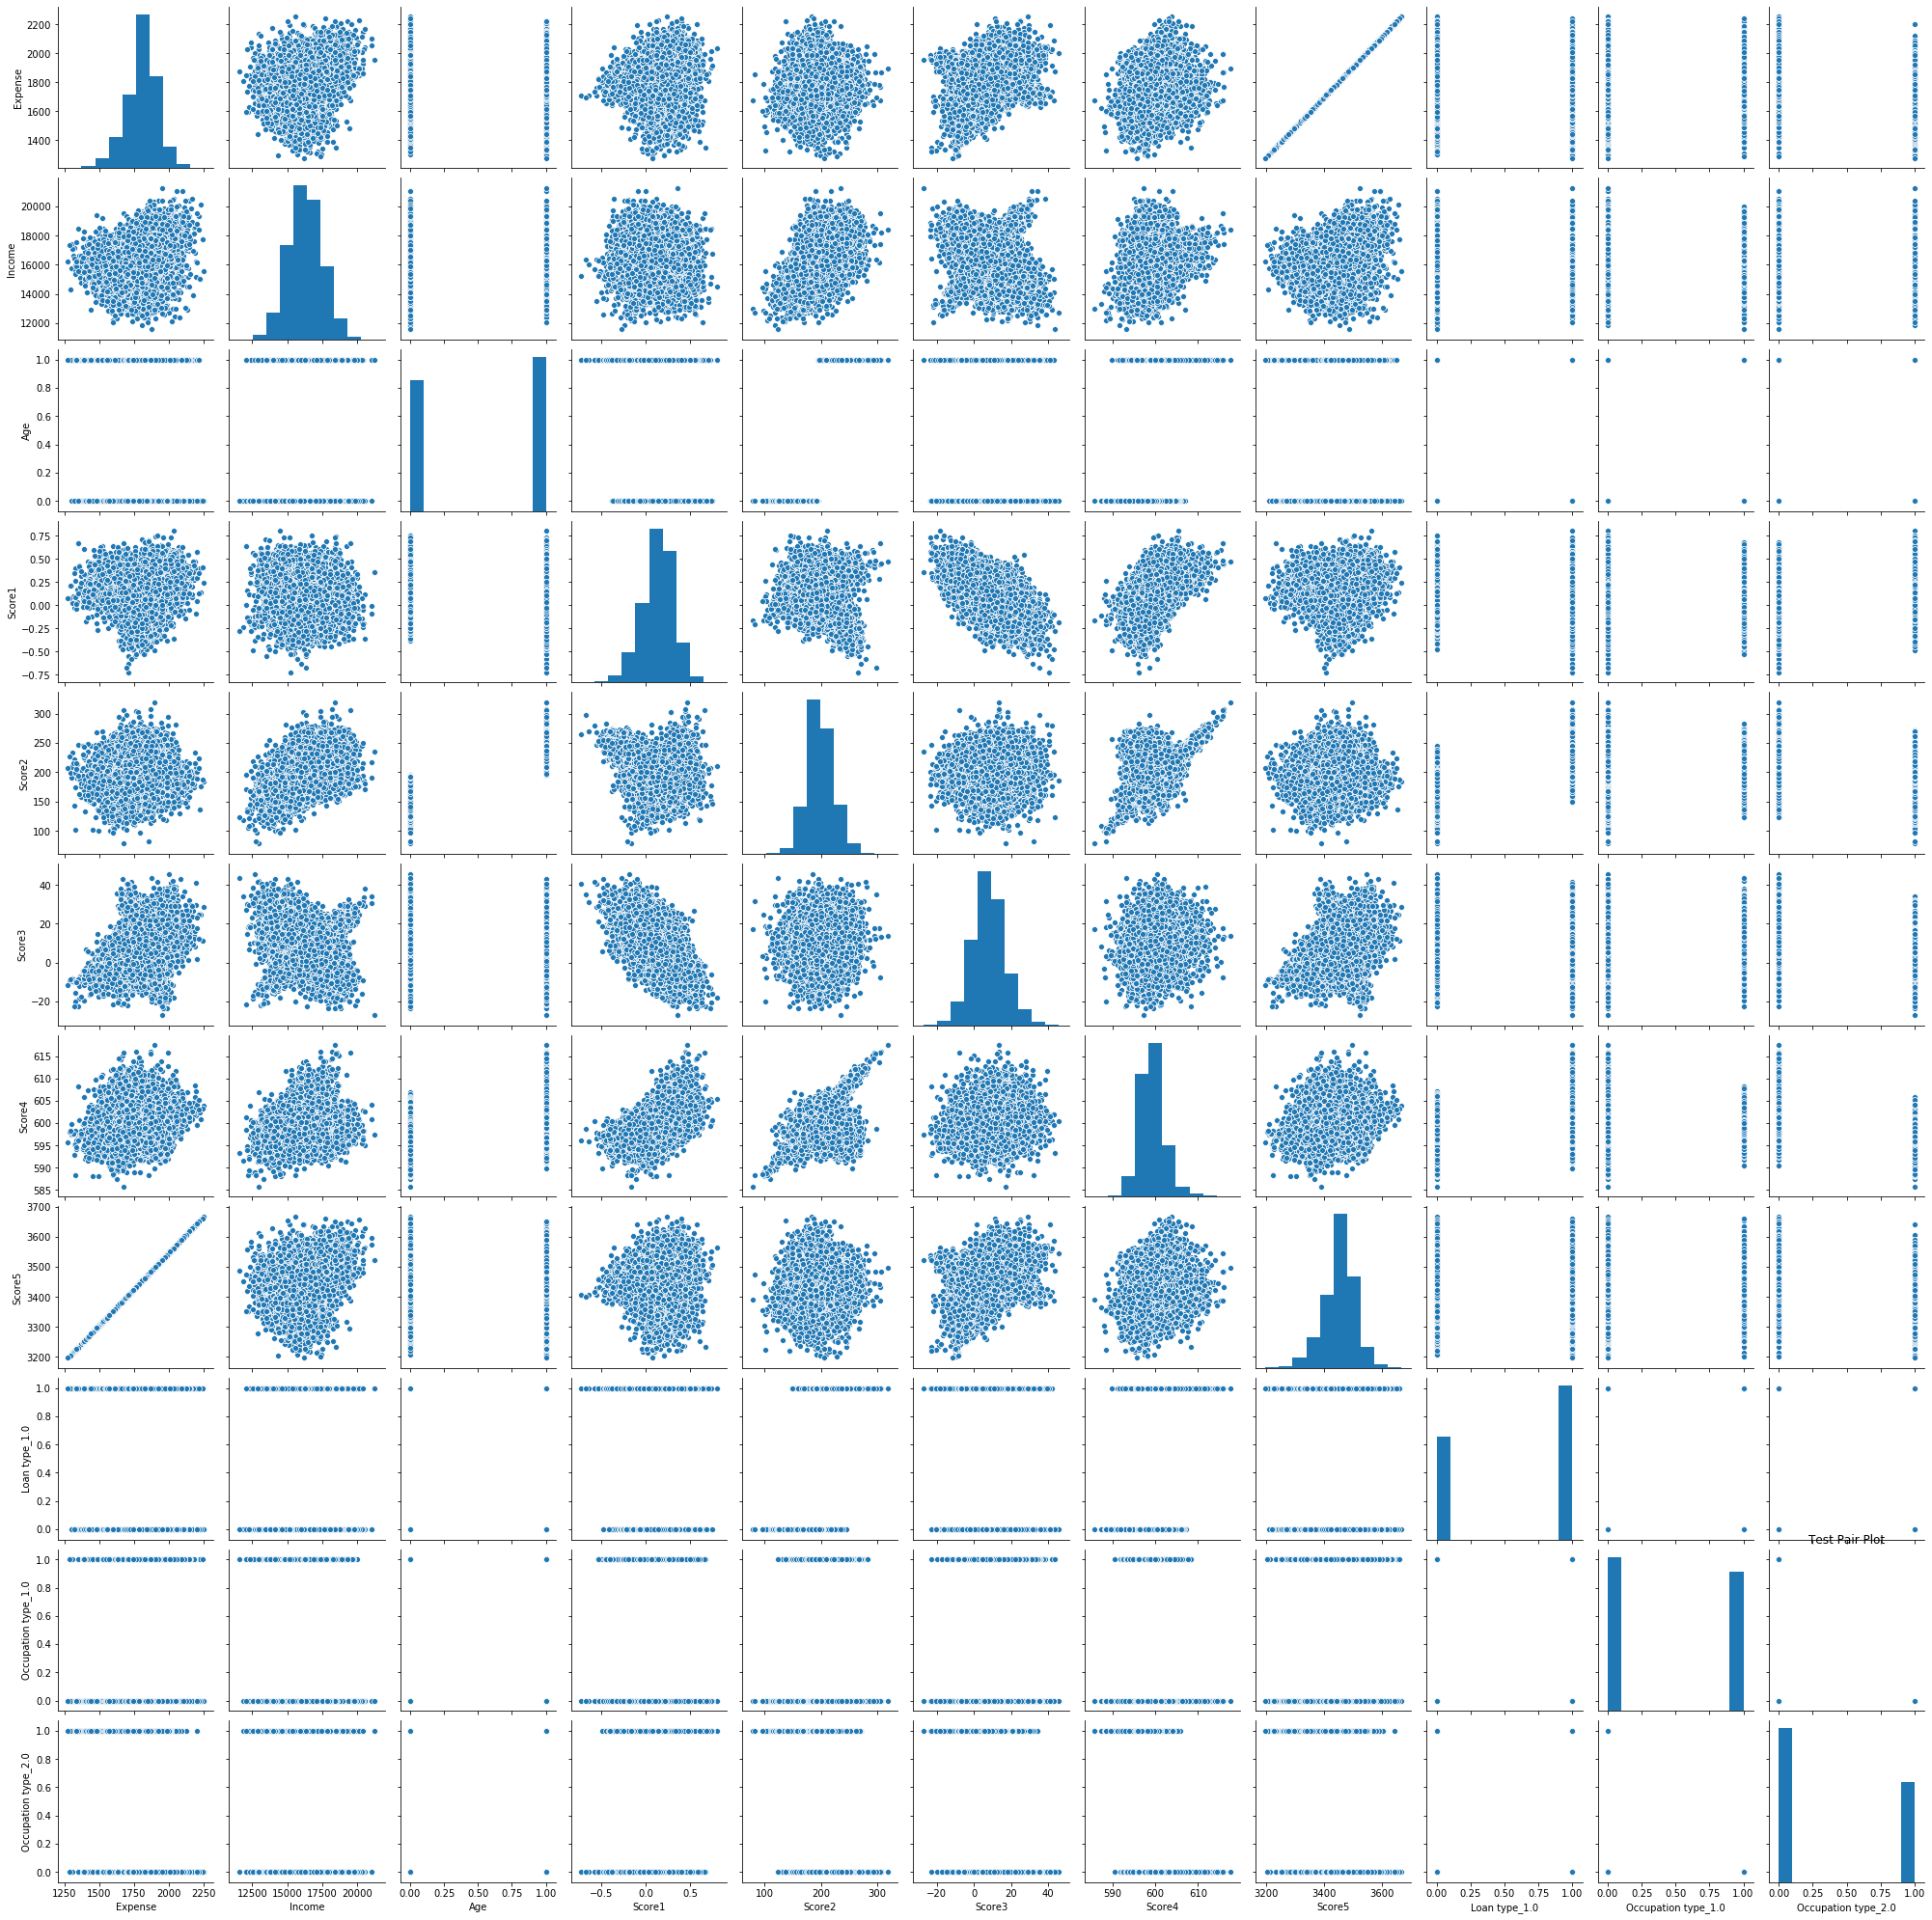

In [13]:
sns.pairplot(df)
plt.title("Train Pair Plot")
plt.show()

sns.pairplot(df_test)
plt.title("Test Pair Plot")
plt.show()

## Analyse Multicollinearity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variance Inflation Factor
X_df = df.drop(["y"], axis=1)

vif = pd.DataFrame()
vif["Features"] = X_df.columns
vif["VIF Factor"]=[variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
vif.sort_values(by=["VIF Factor"], ascending=False)

,Features,VIF Factor
7,Score5,9.051581e+07
6,Score4,5.462307e+07
0,Expense,5.940019e+06
4,Score2,3.707871e+04
3,Score1,3.267527e+03
1,Income,2.267588e+03
5,Score3,1.894692e+03
10,Occupation type_2.0,1.282768e+01
9,Occupation type_1.0,7.769822e+00
8,Loan type_1.0,5.941420e+00


In [15]:
# Use the upper triangle to mask the correlation matrix
upper_triangle = np.triu(np.ones(df.corr().shape)).astype(bool)

# Get the correlation pairs
correlation_pairs = df.corr().mask(upper_triangle).abs().unstack().sort_values(ascending=False)
correlation_pairs = pd.DataFrame(correlation_pairs)
print("Correlation between Features")
display(correlation_pairs.head(7))
print("="*50)

# Display the highly correlated features
highly_correlated = correlation_pairs[correlation_pairs[0]>0.75]
print("Highly Correlated Features")
display(highly_correlated)
print("="*50)

Correlation between Features


,,0
Expense,Score5,1.000000
Score2,Score4,0.786452
Age,Score2,0.780841
Score3,Score5,0.742910
Expense,Score3,0.742909
Age,Loan type_1.0,0.702985
Score2,Loan type_1.0,0.695560


Highly Correlated Features


,,0
Expense,Score5,1.000000
Score2,Score4,0.786452
Age,Score2,0.780841


In [16]:
# Remove each of the highly correlated features and check
highly_correlated.reset_index(inplace=True)
hc_features = highly_correlated["level_0"]

## Remove highly correlated features

In [17]:
df_new = df.copy()
for feature in hc_features:
    print("Removing:", feature, "...")
    df_new = df_new.drop([feature], axis=1)
    upper_triangle = np.triu(np.ones(df_new.corr().shape)).astype(bool)
    c = df_new.corr().mask(upper_triangle).abs().unstack().sort_values(ascending=False)
    c = pd.DataFrame(c)
    print(c[c[0]>0.75])
    print("="*50, "\n")
    if c[c[0]>0.75].size == 0:
        print("The number of highly  correlated fetaures has become zero!")
        print("Preventing all further removals :)")
        break

Removing: Expense ...
                      0
Score2 Score4  0.786452
Age    Score2  0.780841

Removing: Score2 ...
Empty DataFrame
Columns: [0]
Index: []

The number of highly  correlated fetaures has become zero!
Preventing all further removals :)


## Save the final data

In [18]:
df_train = df_new.drop(["y"], axis=1)
final_columns = df_train.columns
df_train["y"] = df_new["y"]
df_train.to_csv("datasets/train_final.csv")

In [19]:
df_test = df_test[final_columns]
df_test.to_csv("datasets/test_final.csv")

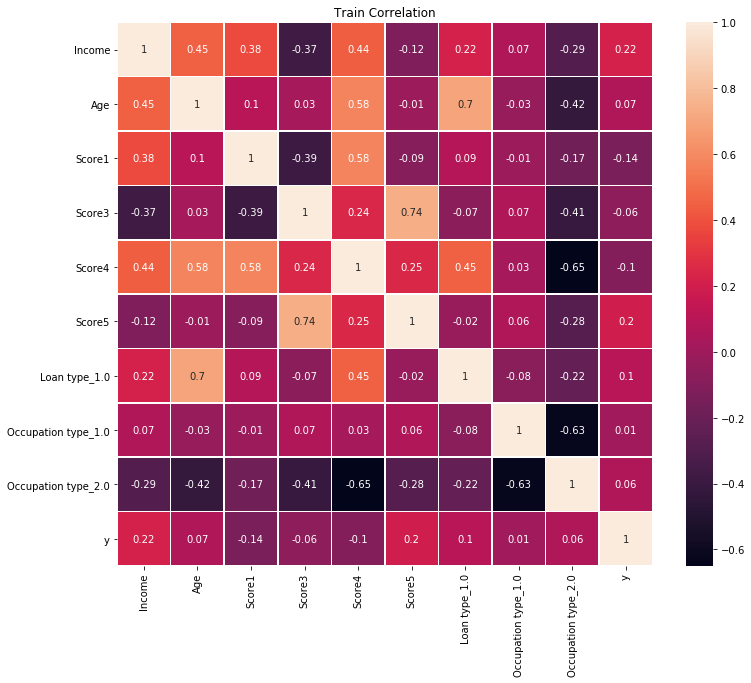

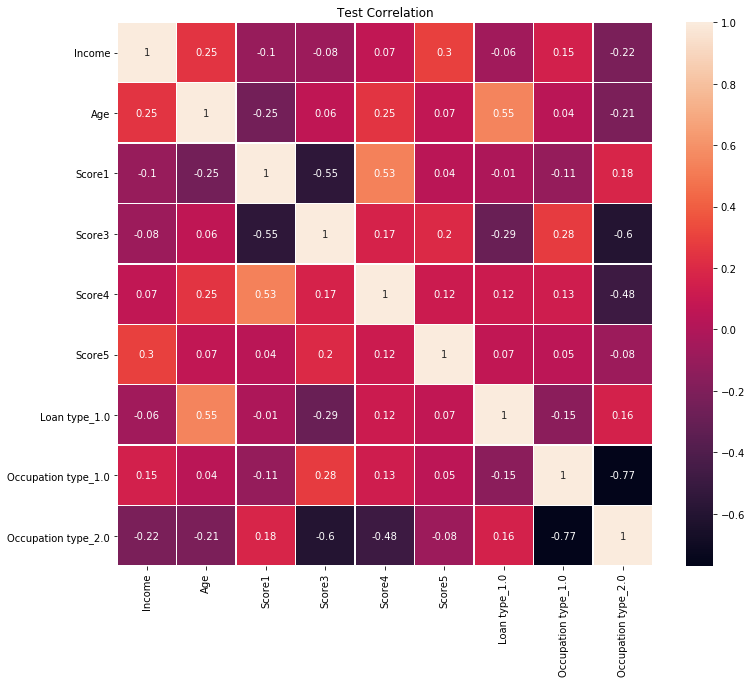

In [20]:
plt.figure(figsize=[12,10])
plt.title("Train Correlation")
sns.heatmap(df_train.corr().round(2), linewidths=.5, annot=True)
plt.show()

plt.figure(figsize=[12,10])
plt.title("Test Correlation")
sns.heatmap(df_test.corr().round(2), linewidths=.5, annot=True)
plt.show()

## Check Multicollinearity again

In [21]:
X_df = df_train.drop(["y"], axis=1)

vif = pd.DataFrame()
vif["Features"] = X_df.columns
vif["VIF Factor"]=[variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
print("After removing related Columns ...")
vif.sort_values(by=["VIF Factor"], ascending=False)

After removing related Columns ...


,Features,VIF Factor
5,Score5,8969.040865
4,Score4,6982.889621
0,Income,569.689564
3,Score3,18.068466
8,Occupation type_2.0,11.882027
7,Occupation type_1.0,7.260461
2,Score1,6.515382
1,Age,5.519235
6,Loan type_1.0,4.289129
